# [Gaussian Mixture Model](https://docs.pymc.io/notebooks/gaussian_mixture_model.html)

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
sns.set_context('paper')
sns.set_style('darkgrid')

In [2]:
import pymc3 as pm, theano.tensor as tt

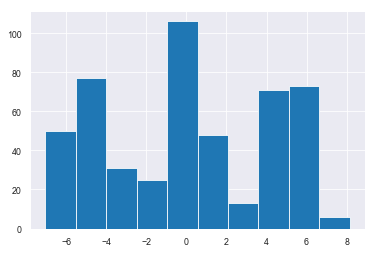

In [3]:
# simulate data from a known mixture distribution
np.random.seed(12345) # set random seed for reproducibility

k = 3
ndata = 500
spread = 5
centers = np.array([-spread, 0, spread])

# simulate data from mixture distribution
v = np.random.randint(0, k, ndata)
data = centers[v] + np.random.randn(ndata)

plt.hist(data);

In [5]:
#setup model
model = pm.Model()
with model:
    # cluster sizes
    p = pm.Dirichlet('p', a=np.array([1., 1., 1.]), shape=k)
    # ensure all clusters have some points
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))


    # cluster centers
    means = pm.Normal('means', mu=[0, 0, 0], sd=15, shape=k)
    # break symmetry
    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0)
                                         + tt.switch(means[2]-means[1] < 0, -np.inf, 0))

    # measurement error
    sd = pm.Uniform('sd', lower=0, upper=20)

    # latent cluster of each observation
    category = pm.Categorical('category',
                              p=p,
                              shape=ndata)

    # likelihood for each observed value
    points = pm.Normal('obs',
                       mu=means[category],
                       sd=sd,
                       observed=data)

In [6]:
# fit model
with model:
    step1 = pm.Metropolis(vars=[p, sd, means])
    step2 = pm.ElemwiseCategorical(vars=[category], values=[0, 1, 2])
    tr = pm.sample(10000, step=[step1, step2])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  after removing the cwd from sys.path.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [means]
>>Metropolis: [sd]
>>Metropolis: [p]
>ElemwiseCategorical: [category]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 21000/21000 [01:36<00:00, 217.47draws/s]
C:\ProgramData\Anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The estimated number of effective samples is smaller than 200 for some parameters.


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


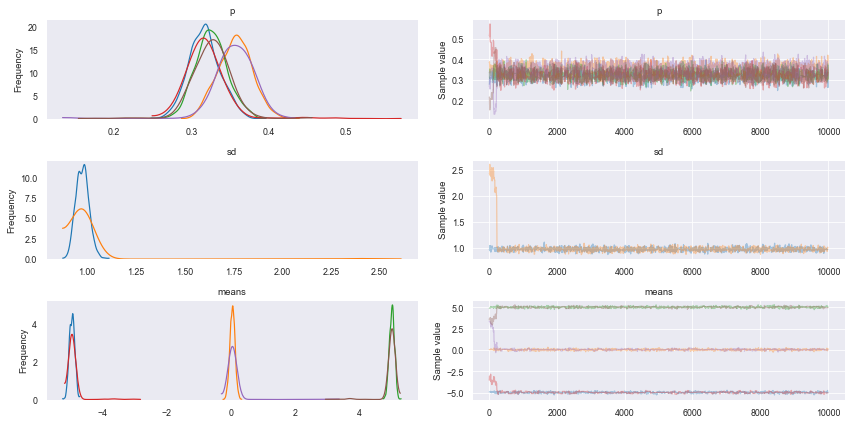

In [7]:
pm.plots.traceplot(tr, ['p', 'sd', 'means']);

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


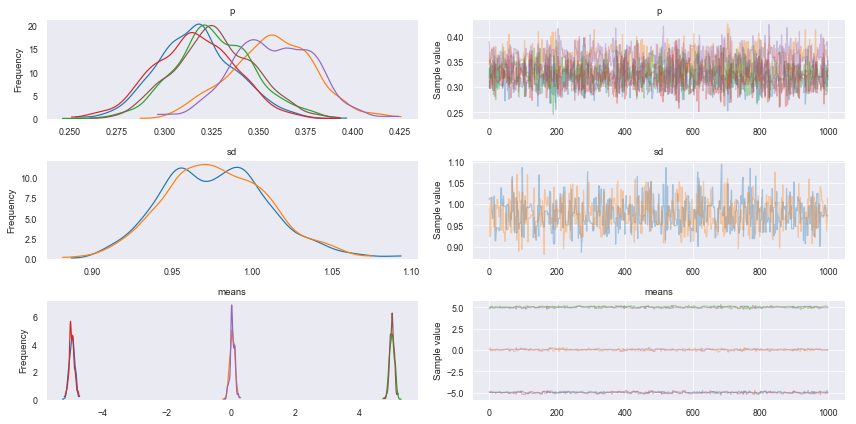

In [8]:
# take a look at traceplot for some model parameters
# (with some burn-in and thinning)
pm.plots.traceplot(tr[5000::5], ['p', 'sd', 'means']);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029AD1119978>,
      dtype=object)

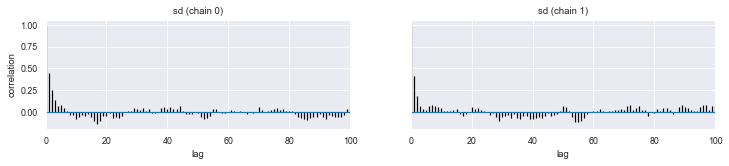

In [9]:
# I prefer autocorrelation plots for serious confirmation of MCMC convergence
pm.autocorrplot(tr[5000::5], varnames=['sd'])

(-149.95000000000002, 3148.95, -0.1, 2.1)

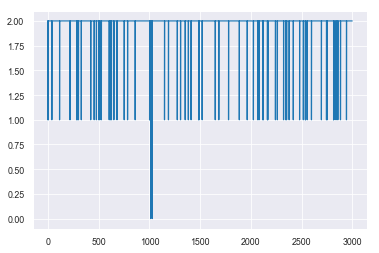

In [10]:
i=0
plt.plot(tr['category'][5000::5, i], drawstyle='steps-mid')
plt.axis(ymin=-.1, ymax=2.1)

true cluster: 2
  data value: 3.29


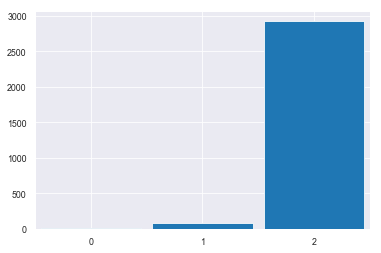

In [11]:
def cluster_posterior(i=0):
    print('true cluster:', v[i])
    print('  data value:', np.round(data[i],2))
    plt.hist(tr['category'][5000::5,i], bins=[-.5,.5,1.5,2.5,], rwidth=.9)
    plt.axis(xmin=-.5, xmax=2.5)
    plt.xticks([0,1,2])
cluster_posterior(i)

In [56]:
for i,b in enumerate((data>-3)&(data<-2)):
    if b: print(i)

57
66
246
458
491


true cluster: 0
  data value: -2.4


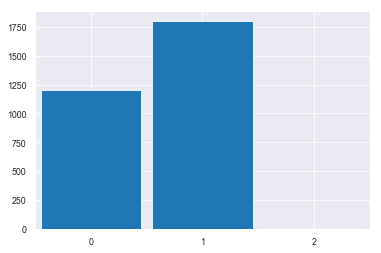

In [65]:
cluster_posterior(246)

In [77]:
correct = np.array([np.argmax(np.bincount(tr['category'][5000::5,i])) == v[i] 
                    for i in range(ndata)])
correct.mean()

0.982